# Hull Tactical Market Prediction - Exploratory Notebook

This notebook loads the provided `train.csv` and `test.csv` for the Hull Tactical Market Prediction-style dataset, performs EDA, feature engineering, trains baseline XGBoost and a small Keras neural network, performs hyperparameter tuning, and simulates a trading strategy that converts predictions into portfolio weights (0-2) and evaluates performance using a Sharpe-like metric that penalizes excess volatility.

Notes: The target column is `market_forward_excess_returns` (daily excess returns versus risk free). The notebook is designed to run in a Kaggle-like environment (Python 3.10+, Pandas, NumPy, scikit-learn, XGBoost, TensorFlow).

In [1]:
# Standard imports
import os
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Add these imports in the first cell
import pyarrow as pa
import pyarrow.parquet as pq
# OR simply
# Print versions for reproducibility
print('pandas', pd.__version__)
print('numpy', np.__version__)
import xgboost as xgb
print('xgboost', xgb.__version__)
print('tensorflow', tf.__version__)
print('scikit-learn', __import__('sklearn').__version__)

pandas 2.2.3
numpy 2.0.2
xgboost 2.1.4
tensorflow 2.18.0
scikit-learn 1.5.2


In [7]:
# Check if Kaggle input path exists
if os.path.exists("/kaggle/input/hull-tactical-market-prediction/train.csv"):
    print("Running in Kaggle environment ✅")
    train = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/train.csv")
    test  = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/test.csv")
else:
    print("Running locally ✅")
    train = pd.read_csv("train.csv")
    test  = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Display few rows
display(train.head())
display(test.head())

print("✔ train.csv and test.csv successfully loaded!")


Running locally ✅
Train shape: (8990, 98)
Test shape : (10, 99)
Train shape: (8990, 98)
Test shape : (10, 99)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V4,V5,V6,V7,V8,V9,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,0,0,0,0,1,0,0,1,0,...,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,True,0.003541,0.000161,0.003068
1,8981,0,0,0,0,1,0,0,1,0,...,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,True,-0.005964,0.000162,-0.006437
2,8982,0,0,0,0,1,0,0,0,1,...,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,True,-0.007410,0.000160,-0.007882
3,8983,0,0,0,0,1,0,0,0,1,...,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,True,0.005420,0.000160,0.004949
4,8984,0,0,0,0,0,0,1,0,1,...,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,True,0.008357,0.000159,0.007887


✔ train.csv and test.csv successfully loaded!


## Basic inspection and target identification
We confirm the target `market_forward_excess_returns` and inspect missing values and basic statistics.

In [8]:
target = 'market_forward_excess_returns'
print('target in columns?', target in train.columns)
display(train.dtypes.value_counts())
missing = train.isna().sum().sort_values(ascending=False)
display(missing[missing>0].head(30))
display(train[[target, 'forward_returns', 'risk_free_rate']].describe().T)

target in columns? True


float64    88
int64      10
Name: count, dtype: int64

E7     6969
V10    6049
S3     5733
M1     5547
M13    5540
M14    5540
M6     5043
V9     4539
S12    3537
M5     3283
M2     3217
S8     3009
M3     2018
E1     1784
P6     1638
E20    1616
P7     1616
P5     1574
V5     1512
V13    1511
V7     1511
S5     1511
E12    1006
E6     1006
E5     1006
E16    1006
E18    1006
E4     1006
E3     1006
E2     1006
dtype: int64

,count,mean,std,min,25%,50%,75%,max
market_forward_excess_returns,8990.0,0.000051,0.010568,-0.040582,-0.004759,0.000252,0.005479,0.040551
forward_returns,8990.0,0.000469,0.010551,-0.039754,-0.004324,0.000659,0.005900,0.040661
risk_free_rate,8990.0,0.000107,0.000088,-0.000004,0.000008,0.000095,0.000193,0.000317


## Visualizations: target series, histogram, boxplot, correlation heatmap
We plot the target series and distributions to understand its behavior.

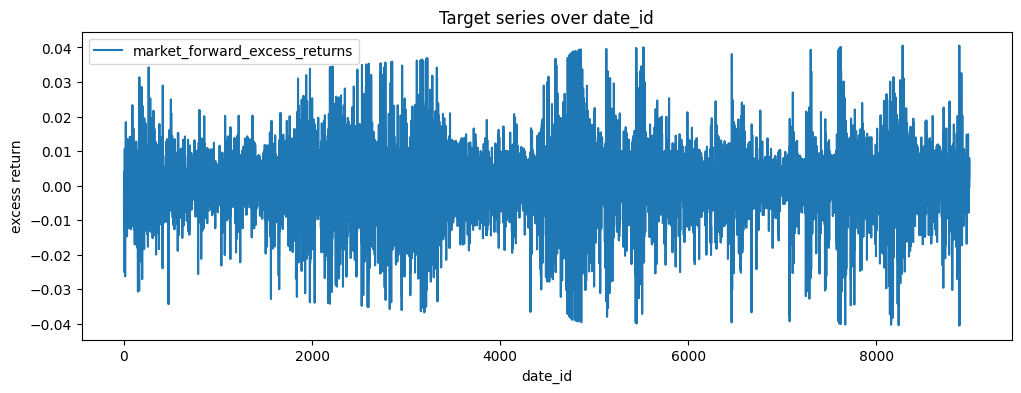

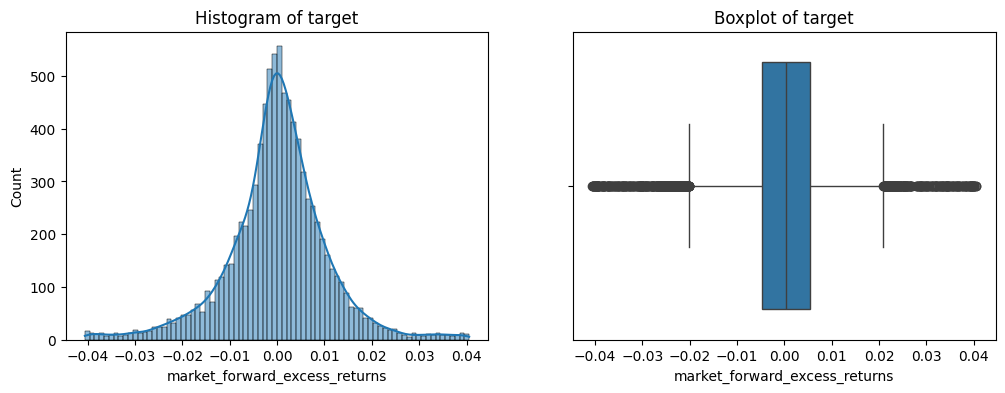

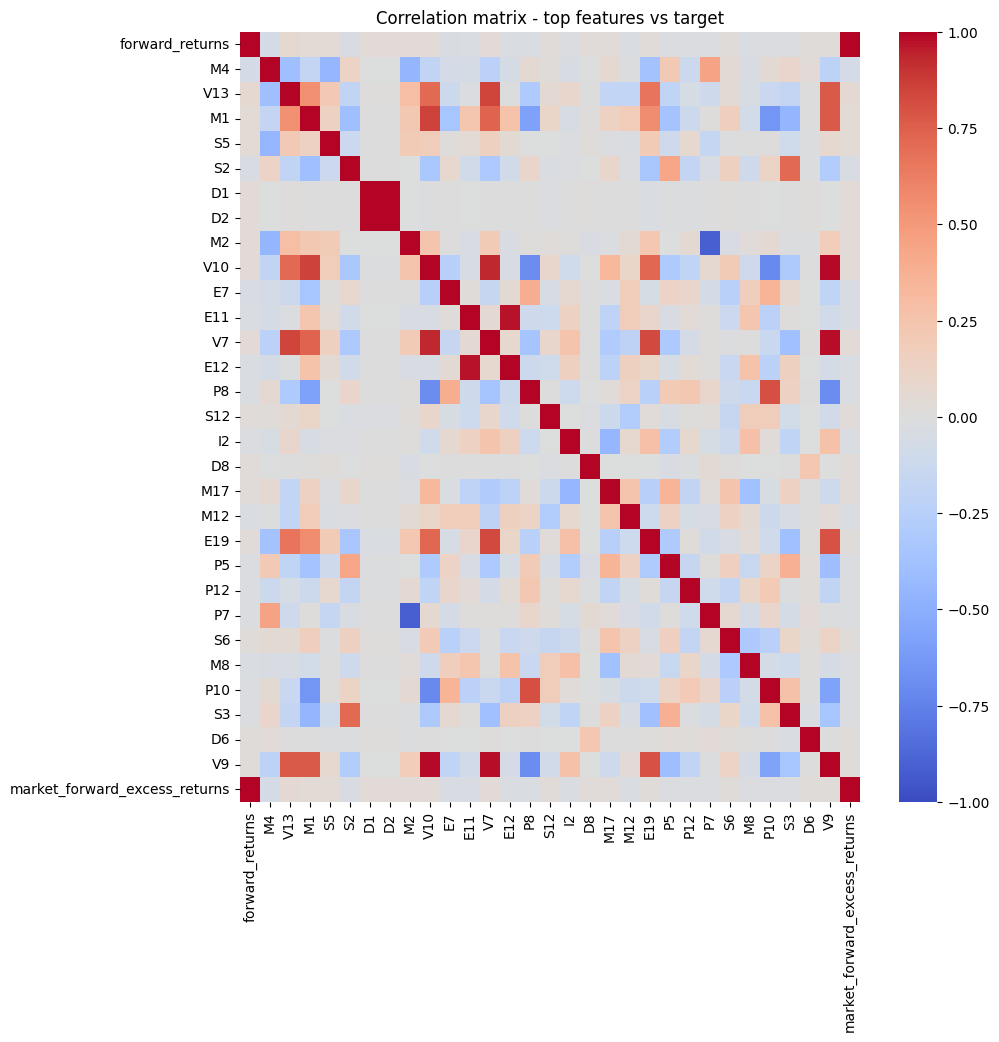

In [9]:
plt.figure(figsize=(12,4))
plt.plot(train['date_id'], train[target], label='market_forward_excess_returns')
plt.xlabel('date_id')
plt.ylabel('excess return')
plt.title('Target series over date_id')
plt.legend()
plt.show()
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.histplot(train[target].dropna(), bins=80, ax=axes[0], kde=True)
axes[0].set_title('Histogram of target')
sns.boxplot(x=train[target].dropna(), ax=axes[1])
axes[1].set_title('Boxplot of target')
plt.show()
corr = train.corr()
corr_target = corr[target].abs().sort_values(ascending=False)
top_feats = corr_target.index[1:31].tolist()
plt.figure(figsize=(10,10))
sns.heatmap(train[top_feats + [target]].corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation matrix - top features vs target')
plt.show()

## Feature engineering
Create lag features, rolling means and rolling volatility for `forward_returns` and the target where appropriate. We'll drop near-constant features and optionally use PCA for dimensionality reduction.

In [10]:
df = train.copy()
for lag in [1,2,3]:
    df[f'forward_returns_lag{lag}'] = df['forward_returns'].shift(lag)
    df[f'{target}_lag{lag}'] = df[target].shift(lag)
df['fr_roll_mean_5'] = df['forward_returns'].rolling(window=5, min_periods=1).mean()
df['fr_roll_std_5'] = df['forward_returns'].rolling(window=5, min_periods=1).std().fillna(0)
df['fr_roll_mean_20'] = df['forward_returns'].rolling(window=20, min_periods=1).mean()
df['fr_roll_std_20'] = df['forward_returns'].rolling(window=20, min_periods=1).std().fillna(0)
nunique = df.nunique()
constant_cols = nunique[nunique<=1].index.tolist()
print('constant or single-value columns:', len(constant_cols))
df.drop(columns=constant_cols, inplace=True, errors='ignore')
df.fillna(0, inplace=True)
print('df shape after feature engineering', df.shape)
display(df.head())

constant or single-value columns: 0
df shape after feature engineering (8990, 108)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,forward_returns_lag1,market_forward_excess_returns_lag1,forward_returns_lag2,market_forward_excess_returns_lag2,forward_returns_lag3,market_forward_excess_returns_lag3,fr_roll_mean_5,fr_roll_std_5,fr_roll_mean_20,fr_roll_std_20
0,0,0,0,0,1,1,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002421,0.000000,-0.002421,0.000000
1,1,0,0,0,1,1,0,0,0,1,...,-0.002421,-0.003038,0.000000,0.000000,0.000000,0.000000,-0.005458,0.004295,-0.005458,0.004295
2,2,0,0,0,1,0,0,0,0,1,...,-0.008495,-0.009114,-0.002421,-0.003038,0.000000,0.000000,-0.006847,0.003874,-0.006847,0.003874
3,3,0,0,0,1,0,0,0,0,0,...,-0.009624,-0.010243,-0.008495,-0.009114,-0.002421,-0.003038,-0.003969,0.006567,-0.003969,0.006567
4,4,0,0,0,1,0,0,0,0,0,...,0.004662,0.004046,-0.009624,-0.010243,-0.008495,-0.009114,-0.005513,0.006652,-0.005513,0.006652


## Prepare training and validation splits (time-aware)
We'll use `date_id` to split the data in time order to avoid lookahead bias. Use the last 20% of time as validation.

In [11]:
features = [c for c in df.columns if c not in ['date_id', target, 'forward_returns', 'risk_free_rate']]
print('selected feature count', len(features))
date_cut = df['date_id'].quantile(0.8)
train_idx = df['date_id'] <= date_cut
val_idx = df['date_id'] > date_cut
X_train = df.loc[train_idx, features].values
y_train = df.loc[train_idx, target].values
X_val = df.loc[val_idx, features].values
y_val = df.loc[val_idx, target].values
print('X_train', X_train.shape, 'X_val', X_val.shape)

selected feature count 104
X_train (7192, 104) X_val (1798, 104)


## Baseline XGBoost model
Train a baseline XGBRegressor and evaluate on the time-validation set.

In [13]:
# Baseline XGBoost with safe-fitting fallback for older xgboost versions
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=4)
# Some xgboost versions accept `early_stopping_rounds` in the sklearn API; others do not. Try the common call and fall back if it fails.
try:
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    print('Fitted XGB with early stopping')
except TypeError as e:
    print('early_stopping_rounds not supported by this xgboost version. Falling back to simple fit. Error:', e)
    xgb_model.fit(X_train, y_train)
    print('Fitted XGB without early stopping')
pred_val = xgb_model.predict(X_val)
print('Baseline XGBoost - MSE', mean_squared_error(y_val, pred_val))
print('Baseline XGBoost - MAE', mean_absolute_error(y_val, pred_val))
print('Baseline XGBoost - R2', r2_score(y_val, pred_val))
# Feature importance (gain) - map back to feature names when possible
try:
    booster = xgb_model.get_booster()
    fi = booster.get_score(importance_type='gain')
    fi2 = {features[int(k.replace('f',''))]:v for k,v in fi.items()}
    sorted_fi = sorted(fi2.items(), key=lambda x: x[1], reverse=True)
    print('Top 15 features by gain')
    for f,v in sorted_fi[:15]:
        print(f, v)
except Exception as e:
    print('feature importance error', e)

early_stopping_rounds not supported by this xgboost version. Falling back to simple fit. Error: fit() got an unexpected keyword argument 'eval_metric'
Fitted XGB without early stopping
Baseline XGBoost - MSE 6.057381951851088e-05
Baseline XGBoost - MAE 0.005383692871289936
Baseline XGBoost - R2 0.5090775109227147
Top 15 features by gain
M4 0.004075767006725073
fr_roll_mean_5 0.0033262695651501417
market_forward_excess_returns_lag2 0.0013565127737820148
fr_roll_std_5 0.0012338078813627362
S3 0.0012319083325564861
forward_returns_lag3 0.0010897070169448853
V5 0.0010591944446787238
forward_returns_lag1 0.0010554897598922253
market_forward_excess_returns_lag3 0.001038875081576407
forward_returns_lag2 0.0009513754048384726
market_forward_excess_returns_lag1 0.0008014698978513479
P2 0.0007822047336958349
V10 0.0007773538818582892
P7 0.0007047177059575915
V9 0.0007004539365880191
Fitted XGB without early stopping
Baseline XGBoost - MSE 6.057381951851088e-05
Baseline XGBoost - MAE 0.0053836928

## Hyperparameter tuning (full run)
Perform a GridSearchCV using TimeSeriesSplit to find reasonable XGBoost params. This grid is larger and will run longer.

In [14]:
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
gsearch = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=4),
                   param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2)
gsearch.fit(X_train, y_train)
print('best params', gsearch.best_params_)
best_xgb = gsearch.best_estimator_
pred_val_g = best_xgb.predict(X_val)
print('Tuned XGBoost - MSE', mean_squared_error(y_val, pred_val_g))
print('Tuned XGBoost - MAE', mean_absolute_error(y_val, pred_val_g))
print('Tuned XGBoost - R2', r2_score(y_val, pred_val_g))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_es

## Keras feedforward network (full train)
Build and train a dense neural network with early stopping (up to 100 epochs).

In [15]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
def build_ffn(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model
ffn = build_ffn(X_train_s.shape[1])
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = ffn.fit(X_train_s, y_train, validation_data=(X_val_s, y_val), epochs=100, batch_size=128, callbacks=[es], verbose=2)
pred_val_nn = ffn.predict(X_val_s).ravel()
print('NN - MSE', mean_squared_error(y_val, pred_val_nn))
print('NN - MAE', mean_absolute_error(y_val, pred_val_nn))
print('NN - R2', r2_score(y_val, pred_val_nn))

Epoch 1/100
57/57 - 4s - 66ms/step - loss: 0.1471 - mae: 0.2745 - val_loss: 0.0948 - val_mae: 0.2153
Epoch 2/100
57/57 - 4s - 66ms/step - loss: 0.1471 - mae: 0.2745 - val_loss: 0.0948 - val_mae: 0.2153
Epoch 2/100
57/57 - 1s - 9ms/step - loss: 0.0349 - mae: 0.1455 - val_loss: 0.0497 - val_mae: 0.1641
Epoch 3/100
57/57 - 1s - 9ms/step - loss: 0.0349 - mae: 0.1455 - val_loss: 0.0497 - val_mae: 0.1641
Epoch 3/100
57/57 - 0s - 3ms/step - loss: 0.0198 - mae: 0.1091 - val_loss: 0.0253 - val_mae: 0.1202
Epoch 4/100
57/57 - 0s - 3ms/step - loss: 0.0198 - mae: 0.1091 - val_loss: 0.0253 - val_mae: 0.1202
Epoch 4/100
57/57 - 0s - 3ms/step - loss: 0.0116 - mae: 0.0827 - val_loss: 0.0147 - val_mae: 0.0933
Epoch 5/100
57/57 - 0s - 3ms/step - loss: 0.0116 - mae: 0.0827 - val_loss: 0.0147 - val_mae: 0.0933
Epoch 5/100
57/57 - 0s - 3ms/step - loss: 0.0070 - mae: 0.0636 - val_loss: 0.0099 - val_mae: 0.0763
Epoch 6/100
57/57 - 0s - 3ms/step - loss: 0.0070 - mae: 0.0636 - val_loss: 0.0099 - val_mae: 0.076

## Strategy Simulation & Competition-style Scoring
Convert predictions to portfolio weights in [0,2], apply a 120% volatility cap relative to market volatility, include transaction costs, and compute an adjusted Sharpe ratio similar to the competition metric.

Strategy net mean daily 0.004220918822935001
Market mean daily 0.0006116292754253909
Strategy net Sharpe 4.913067613114813
Market Sharpe 0.8753075200173095
market vol 0.011092460103463155 strategy vol 0.01363812068842764 cap 0.013310952124155786
Adjusted Strategy Sharpe 4.913067612973249


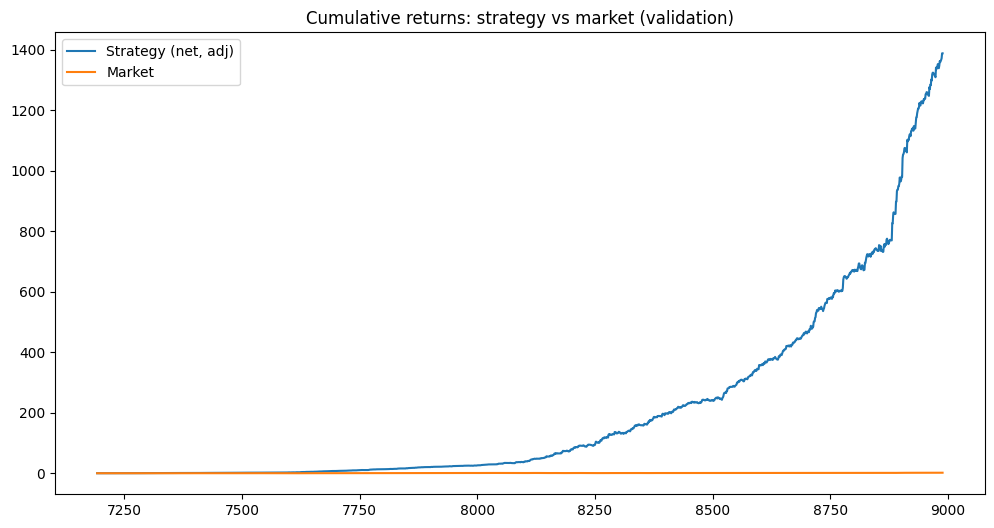

,date_id,pred,weight,weight_adj,forward_returns,strategy_excess_adj
0,7192,-0.003062,0.823525,0.803769,-0.003771,-0.003031
1,7193,-0.000732,1.011479,0.987215,-0.001143,-0.001220
2,7194,0.002305,1.256476,1.226334,0.001859,0.002161
3,7195,0.005765,1.535583,1.498745,0.005032,0.007406
4,7196,0.004002,1.393348,1.359923,0.008522,0.011520


In [16]:
# Use tuned XGBoost predictions as primary signal
signal = pred_val_g
def signal_to_weight(s, lower=0.0, upper=2.0):
    lo = np.percentile(s, 5)
    hi = np.percentile(s, 95)
    w = (s - lo) / (hi - lo + 1e-9) * (upper - lower) + lower
    return np.clip(w, lower, upper)
weights = signal_to_weight(signal)
val_df = df.loc[val_idx].copy().reset_index(drop=True)
val_df['pred'] = signal
val_df['weight'] = weights
# transaction cost per round-trip (default 5 bps)
tc = 0.0005
# compute turnover as abs change in weight (day-over-day) and apply cost
val_df['turnover'] = val_df['weight'].diff().abs().fillna(0)
val_df['tc_cost'] = val_df['turnover'] * tc
# strategy excess returns before cost
val_df['strategy_excess'] = val_df['weight'] * val_df['forward_returns']
# subtract transaction cost from strategy returns
val_df['strategy_excess_net'] = val_df['strategy_excess'] - val_df['tc_cost']
# Sharpe function
def sharpe_ratio(returns, periods=252):
    mean = returns.mean()
    vol = returns.std()
    if vol == 0: return np.nan
    return (mean/vol) * np.sqrt(periods)
strat_ret = val_df['strategy_excess_net']
market_ret = val_df['forward_returns']
print('Strategy net mean daily', strat_ret.mean())
print('Market mean daily', market_ret.mean())
print('Strategy net Sharpe', sharpe_ratio(strat_ret))
print('Market Sharpe', sharpe_ratio(market_ret))
# volatility cap: scale weights to keep strategy vol <= 1.2 * market vol
market_vol = market_ret.std()
strat_vol = strat_ret.std()
cap = 1.2 * market_vol
print('market vol', market_vol, 'strategy vol', strat_vol, 'cap', cap)
if strat_vol > cap and strat_vol>0:
    scale = cap / strat_vol
    val_df['weight_adj'] = val_df['weight'] * scale
    val_df['turnover_adj'] = val_df['weight_adj'].diff().abs().fillna(0)
    val_df['tc_cost_adj'] = val_df['turnover_adj'] * tc
    val_df['strategy_excess_adj'] = val_df['weight_adj'] * val_df['forward_returns'] - val_df['tc_cost_adj']
    print('Adjusted Strategy Sharpe', sharpe_ratio(val_df['strategy_excess_adj']))
else:
    val_df['weight_adj'] = val_df['weight']
    val_df['strategy_excess_adj'] = val_df['strategy_excess_net']
# cumulative returns
val_df['cum_strategy'] = (1 + val_df['strategy_excess_adj']).cumprod() - 1
val_df['cum_market'] = (1 + val_df['forward_returns']).cumprod() - 1
plt.figure(figsize=(12,6))
plt.plot(val_df['date_id'], val_df['cum_strategy'], label='Strategy (net, adj)')
plt.plot(val_df['date_id'], val_df['cum_market'], label='Market')
plt.legend()
plt.title('Cumulative returns: strategy vs market (validation)')
plt.show()
display(val_df[['date_id','pred','weight','weight_adj','forward_returns','strategy_excess_adj']].head())

## Discussion & Next steps
- The notebook shows a complete flow from data loading to strategy simulation.
- Next improvements: cross-sectional signals (if available), ensemble models, rolling retraining, transaction cost models, stricter backtest hygiene to avoid data leakage, and using PCA/feature selection for correlated features.
- Be mindful that beating the S&P on historical data does not guarantee future performance and may reflect data snooping.

If you'd like, I can re-run this notebook now (full run will take time), or run a quicker version first.

In [18]:
# Submission generation cell - robust to missing columns in test.csv
print('Preparing submission file...')
import joblib
# Look for test.csv in common locations (Kaggle path first, then workspace paths)
kaggle_test_path = '/kaggle/input/hull-tactical-market-prediction/test.csv'
local_test_paths = [
    r'c:\\Users\\zs\\Desktop\\streamlitwebapp\\notebook\\kaggle\\competitions\\test.csv',
    r'c:\\Users\\zs\\Desktop\\streamlitwebapp\\test.csv',
    'test.csv'
]
test_path = None
if os.path.exists(kaggle_test_path):
    test_path = kaggle_test_path
else:
    for p in local_test_paths:
        if os.path.exists(p):
            test_path = p
            break
if test_path is None:
    raise FileNotFoundError('test.csv not found in expected locations; please place test.csv in the notebook folder or provide the Kaggle input path.')
test_df = pd.read_csv(test_path)
# ---------- Recreate derived features safely ----------
# Create lag features for forward_returns if available; otherwise create zero columns so model input shape matches
for lag in [1,2,3]:
    if 'forward_returns' in test_df.columns:
        test_df[f'forward_returns_lag{lag}'] = test_df['forward_returns'].shift(lag).fillna(0)
    else:
        test_df[f'forward_returns_lag{lag}'] = 0.0
    # target lag columns are not available in test set; create zeros
    test_df[f'{target}_lag{lag}'] = 0.0
# Rolling statistics: use forward_returns when present, otherwise zeros
if 'forward_returns' in test_df.columns:
    test_df['fr_roll_mean_5'] = test_df['forward_returns'].rolling(window=5, min_periods=1).mean().fillna(0)
    test_df['fr_roll_std_5'] = test_df['forward_returns'].rolling(window=5, min_periods=1).std().fillna(0)
    test_df['fr_roll_mean_20'] = test_df['forward_returns'].rolling(window=20, min_periods=1).mean().fillna(0)
    test_df['fr_roll_std_20'] = test_df['forward_returns'].rolling(window=20, min_periods=1).std().fillna(0)
else:
    test_df['fr_roll_mean_5'] = 0.0
    test_df['fr_roll_std_5'] = 0.0
    test_df['fr_roll_mean_20'] = 0.0
    test_df['fr_roll_std_20'] = 0.0
# ---------- Prepare feature matrix for test set ----------
# Prefer the 'features' list from earlier in the notebook if available; otherwise attempt to reconstruct from training df or test columns
if 'features' in globals():
    feat_list = features
else:
    if 'df' in globals():
        feat_list = [c for c in df.columns if c not in ['date_id', target, 'forward_returns', 'risk_free_rate']]
    else:
        feat_list = [c for c in test_df.columns if c not in ['date_id', target, 'forward_returns', 'risk_free_rate']]
# Ensure test_df contains all required columns (add missing ones as zeros)
for f in feat_list:
    if f not in test_df.columns:
        test_df[f] = 0.0
# Build X_test in the same column order as feat_list
X_test = test_df[feat_list].values
# ---------- Load or train model ----------
model = None
# Prefer tuned model object 'best_xgb' if present
if 'best_xgb' in globals():
    model = best_xgb
    print('Using tuned model: best_xgb')
# Else try to load saved joblib artifact
elif os.path.exists('xgb_model.joblib'):
    try:
        model = joblib.load('xgb_model.joblib')
        print('Loaded model from xgb_model.joblib')
    except Exception as e:
        print('Failed to load xgb_model.joblib:', e)
# Else try a baseline variable 'xgb_model' in notebook
elif 'xgb_model' in globals():
    model = xgb_model
    print('Using baseline model: xgb_model')
else:
    # Fallback: train quickly on available training df (if present)
    if 'df' in globals():
        print('No existing model found; training quick fallback XGBoost on training data...')
        feat_local = [c for c in df.columns if c in feat_list]
        X_full = df[feat_local].values
        y_full = df[target].values
        model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=4)
        model.fit(X_full, y_full)
        try:
            joblib.dump(model, 'xgb_model.joblib')
            print('Saved fallback model to xgb_model.joblib')
        except Exception as e:
            print('Could not save fallback model:', e)
    else:
        raise RuntimeError('No trained model available and training data (df) not found in the notebook.')
# ---------- Predict and map to weights ----------
preds = model.predict(X_test)
# Use existing signal_to_weight if available, else define locally
if 'signal_to_weight' in globals():
    weights = signal_to_weight(preds)
else:
    def _signal_to_weight_local(s, lower=0.0, upper=2.0):
        lo = np.percentile(s, 5)
        hi = np.percentile(s, 95)
        w = (s - lo) / (hi - lo + 1e-9) * (upper - lower) + lower
        return np.clip(w, lower, upper)
    weights = _signal_to_weight_local(preds)
# ---------- Build submission dataframe and save ----------
if 'date_id' in test_df.columns:
    date_col = test_df['date_id']
else:
    date_col = np.arange(len(test_df))
submission = pd.DataFrame({'date_id': date_col, 'market_forward_excess_returns_pred': preds, 'weight': weights})
out_path = os.path.join(os.getcwd(), 'submission.parquet')
try:
    submission.to_parquet(out_path, index=False)
    print('Saved submission to', out_path)
except Exception as e:
    csv_out = out_path.replace('.parquet', '.csv')
    submission.to_csv(csv_out, index=False)
    print('Parquet write failed (fallback to CSV):', e)
    print('Saved CSV fallback to', csv_out)
print('Submission generation complete.')

Preparing submission file...
Using tuned model: best_xgb
Saved submission to c:\Users\zs\Desktop\streamlitwebapp\notebook\kaggle\competitions\submission.parquet
Submission generation complete.
Saved submission to c:\Users\zs\Desktop\streamlitwebapp\notebook\kaggle\competitions\submission.parquet
Submission generation complete.
